# 🏠 EstateMind – Data Pipeline Notebook

This notebook documents the **end-to-end data pipeline** for the EstateMind project.

**Goals of this notebook:**
- Load and inspect raw data
- Clean and preprocess datasets
- Perform transformations and feature preparation
- Prepare data for analytics or machine learning workflows

Each section contains explanations written for clarity, revision, and future maintenance.

## 🔹 Step 1

This step performs a specific operation in the data pipeline. Read the comments in the code carefully to understand *what* is done and *why* it matters.

In [6]:
# --- Explained step-by-step ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load
df = pd.read_csv('tayara_real_estate_p1_p317.csv')
print(f"Raw shape: {df.shape}")
display(df.head())


Raw shape: (9510, 6)


,page,title,price,location,listing_date,url
0,1,عقاري تجاري,NaN,Gafsa,a minute ago,https://www.tayara.tn/item/magasins%2c-commerc...
1,1,Studio Luxe à louer,270 DT,Ariana,2 minutes ago,https://www.tayara.tn/item/appartements/ariana...
2,1,📍ENNASR 2 : APPARTEMENT S+3 A LOUER,1450 DT,Ariana,2 minutes ago,https://www.tayara.tn/item/appartements/ariana...
3,1,A louer s1 meublé manar1,800 DT,Tunis,3 minutes ago,https://www.tayara.tn/item/appartements/tunis/...
4,1,📍 NOUVELLE ARIANA : BUREAU H+3 SPACIEUX À LOUER,1400 DT,Ariana,3 minutes ago,https://www.tayara.tn/item/bureaux-et-plateaux...


## 🔹 Step 2

This step performs a specific operation in the data pipeline. Read the comments in the code carefully to understand *what* is done and *why* it matters.

In [7]:
# --- Explained step-by-step ---
def clean_data(df):
    df_clean = df.copy()

    # Price numeric
    df_clean['price_num'] = df_clean['price'].astype(str).str.extract(r'([\d,\.]+)').astype(float).replace(',','.', regex=True)
    df_clean['price_num'] = pd.to_numeric(df_clean['price_num'], errors='coerce')

    # Type classification
    df_clean['type'] = np.where(df_clean['title'].str.contains(r'\b(vendre|VENDRE|vente|VENDE)\b', regex=True, case=False, na=False), 'sale',
                                np.where(df_clean['title'].str.contains(r'\b(louer|LOUER|rent|location)\b', regex=True, case=False, na=False), 'rent', 'other'))

    # Bedrooms
    df_clean['bedrooms'] = df_clean['title'].str.extract(r'S(\d+)', expand=False).astype('Int64')

    # Location standardize
    df_clean['location_clean'] = df_clean['location'].str.strip().str.title()

    # Age approx hours
    def parse_date(date_str):
        if pd.isna(date_str): return np.nan
        nums = re.findall(r'(\d+)', str(date_str).lower())
        if not nums: return 0
        unit = re.search(r'(minute|hour|day|jours?|heures?)', str(date_str).lower())
        unit = unit.group(1)[0] if unit else 'm'
        val = float(nums[0])
        if 'd' in unit: return val * 24
        elif 'h' in unit: return val
        return val / 60  # minutes to hours
    df_clean['age_hours'] = df_clean['listing_date'].apply(parse_date)

    # Filter valid
    df_clean = df_clean[(df_clean['price_num'] > 0) & (df_clean['type'] != 'other')].copy()

    return df_clean

df_clean = clean_data(df)
print(f"Cleaned shape: {df_clean.shape}")
display(df_clean.head())
df_clean.to_csv('cleaned_estate_data.csv', index=False)


Cleaned shape: (4516, 11)


,page,title,price,location,listing_date,url,price_num,type,bedrooms,location_clean,age_hours
1,1,Studio Luxe à louer,270 DT,Ariana,2 minutes ago,https://www.tayara.tn/item/appartements/ariana...,270.0,rent,<NA>,Ariana,0.033333
2,1,📍ENNASR 2 : APPARTEMENT S+3 A LOUER,1450 DT,Ariana,2 minutes ago,https://www.tayara.tn/item/appartements/ariana...,1450.0,rent,<NA>,Ariana,0.033333
3,1,A louer s1 meublé manar1,800 DT,Tunis,3 minutes ago,https://www.tayara.tn/item/appartements/tunis/...,800.0,rent,<NA>,Tunis,0.050000
4,1,📍 NOUVELLE ARIANA : BUREAU H+3 SPACIEUX À LOUER,1400 DT,Ariana,3 minutes ago,https://www.tayara.tn/item/bureaux-et-plateaux...,1400.0,rent,<NA>,Ariana,0.050000
5,1,ENNASR 1 : APPARTEMENT S+3 RICHEMENT MEUBLÉ OU...,1400 DT,Ariana,3 minutes ago,https://www.tayara.tn/item/appartements/ariana...,1400.0,rent,<NA>,Ariana,0.050000


## 🔹 Step 3

This step performs a specific operation in the data pipeline. Read the comments in the code carefully to understand *what* is done and *why* it matters.

In [8]:
# --- Explained step-by-step ---
def eda_analysis(df):
    print("=== Dataset Overview ===")
    print(df['type'].value_counts())
    print("\nPrice Stats by Type (DT):")
    print(df.groupby('type')['price_num'].agg(['count', 'mean', 'median', 'min', 'max']).round(0))
    print("\nTop 10 Locations:")
    print(df['location_clean'].value_counts().head(10))
    print("\nBedrooms Distribution:")
    print(df['bedrooms'].value_counts().sort_index())

eda_analysis(df_clean)


=== Dataset Overview ===
type
rent    2496
sale    2020
Name: count, dtype: int64

Price Stats by Type (DT):
      count       mean    median  min           max
type                                               
rent   2496    26481.0    1300.0  2.0  5.865118e+07
sale   2020  4367783.0  270000.0  2.0  1.900000e+09

Top 10 Locations:
location_clean
Tunis         2022
Ariana         867
Sousse         413
Nabeul         364
Ben Arous      324
Sfax           188
Bizerte        110
La Manouba      63
Monastir        58
Médenine        28
Name: count, dtype: int64

Bedrooms Distribution:
bedrooms
0        7
1       73
2       72
3       65
4       14
5        4
6        3
8        1
1191     1
Name: count, dtype: Int64


## 🔹 Step 4

This step performs a specific operation in the data pipeline. Read the comments in the code carefully to understand *what* is done and *why* it matters.

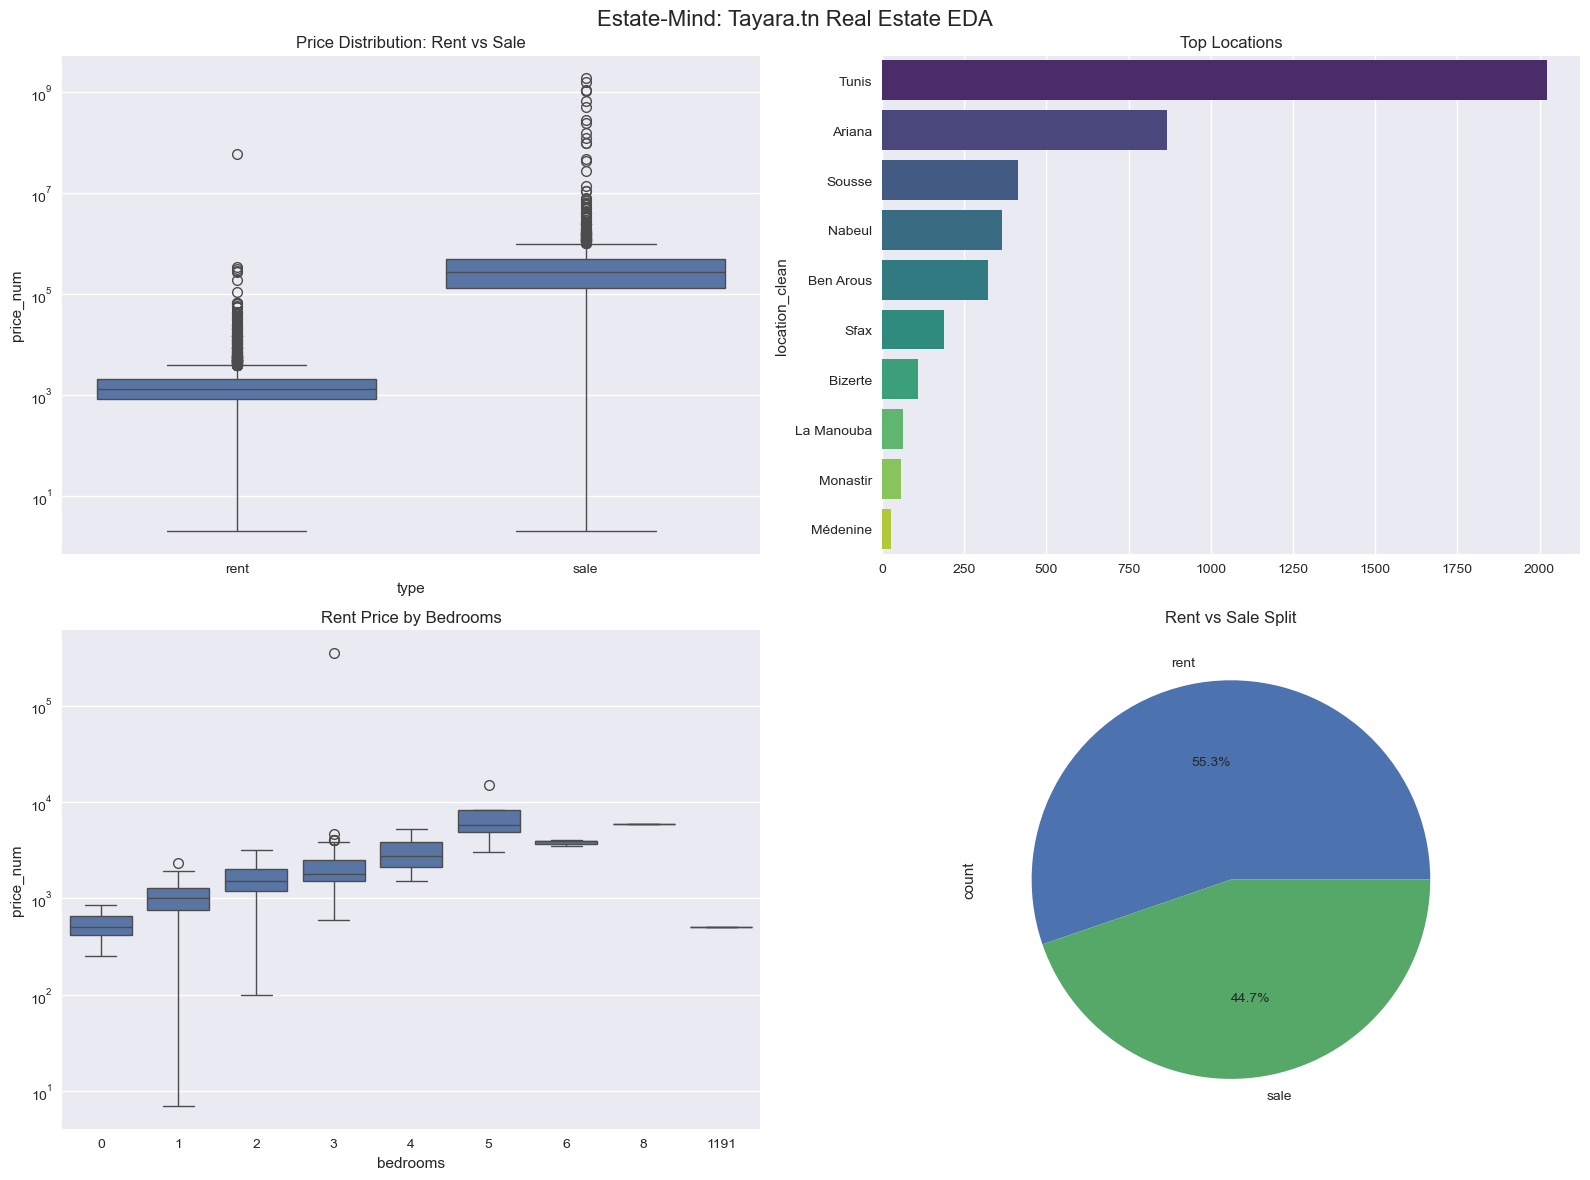

In [9]:
# --- Explained step-by-step ---
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Estate-Mind: Tayara.tn Real Estate EDA', fontsize=16)

# 1. Price by Type (log scale)
sns.boxplot(data=df_clean, x='type', y='price_num', ax=axes[0,0])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Price Distribution: Rent vs Sale')

# 2. Listings by Location
top_locs = df_clean['location_clean'].value_counts().head(10)
sns.barplot(x=top_locs.values, y=top_locs.index, ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Top Locations')

# 3. Rent Price by Bedrooms
rent_df = df_clean[df_clean['type']=='rent']
if len(rent_df)>0:
    sns.boxplot(data=rent_df, x='bedrooms', y='price_num', ax=axes[1,0])
    axes[1,0].set_yscale('log')
    axes[1,0].set_title('Rent Price by Bedrooms')

# 4. Type Proportion
df_clean['type'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1,1])
axes[1,1].set_title('Rent vs Sale Split')

plt.tight_layout()
plt.savefig('estate_eda_visuals.png', dpi=300, bbox_inches='tight')
plt.show()


## 🔹 Step 5

This step performs a specific operation in the data pipeline. Read the comments in the code carefully to understand *what* is done and *why* it matters.

In [10]:
# --- Explained step-by-step ---
# Correlation matrix
corr_cols = ['price_num', 'age_hours', 'bedrooms']
corr_df = df_clean[corr_cols].dropna()
print("Correlation Matrix:")
print(corr_df.corr().round(3))

# Avg price by location/type
pivot = df_clean.groupby(['location_clean', 'type'])['price_num'].agg(['mean', 'count']).round(0)
print("\nAvg Price by Location & Type:")
print(pivot[pivot['count'] >= 5])

# Export subsets
df_clean[df_clean['type']=='rent'].to_csv('rentals_clean.csv', index=False)
df_clean[df_clean['type']=='sale'].to_csv('sales_clean.csv', index=False)
print("\nExported: cleaned_estate_data.csv, rentals_clean.csv, sales_clean.csv")


Correlation Matrix:
           price_num  age_hours  bedrooms
price_num      1.000     -0.073    -0.030
age_hours     -0.073      1.000    -0.055
bedrooms      -0.030     -0.055     1.000

Avg Price by Location & Type:
                           mean  count
location_clean type                   
Ariana         rent      2150.0    494
               sale    922738.0    373
Ben Arous      rent      4067.0    155
               sale  10605750.0    169
Bizerte        rent       919.0     49
               sale   2354049.0     61
Béja           sale    291489.0      7
Gabès          rent       734.0      7
La Manouba     rent       717.0     17
               sale    215363.0     46
Mahdia         rent       630.0      8
               sale    273927.0      9
Monastir       rent       601.0     25
               sale    520540.0     33
Médenine       rent       156.0      8
               sale    204327.0     20
Nabeul         rent      1341.0     93
               sale  13290064.0    271
S